<a href="https://colab.research.google.com/github/thaygorh/predicao-de-taxa/blob/main/predicao_fluxo_motor_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: *Machine Learning & Analytics* - Predição de Fluxo de Massa a partir da Corrente de um Motor
**Autor:** Thaygor Henrique Gonçalves  

**Data:** 28/09/2025

**Matrícula:** 4052025000871

**Dataset:**  [Motor Current Dataset](https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/refs/heads/main/MVP_MLA_dados_tratados2.csv)

---

## ✅ Checklist do MVP (o que precisa conter)
- [X] **Problema definido e contexto de negócio** → Checklist respondido, definição clara do problema, hipóteses e dataset.  
- [X] **Tratamento dos dados** → Pré-processamento, normalização e tratamento.  
- [X] **Carga e preparação dos dados** → Ordenação temporal, configuração de features e target.  
- [X] **Divisão em treino/validação/teste** → 90% treino+val / 10% teste holdout.  
- [X] **Modelagem (com baseline)** → Comparação entre DummyRegressor, Ridge, RandomForest, GradientBoosting, LightGBM, CatBoost.  
- [X] **Otimização de hiperparâmetros** → GridSearchCV com TimeSeriesSplit.  
- [X] **Salvando artefatos** → Salvar e recarregar o melhor modelo, sem precisar retreinar.  
- [X] **Boas práticas** → Seeds fixadas, tempo de treino, documentação em Markdown explicativa, uso de Pipeline.  
- [X] **Avaliação e discussão de limitações** → Holdout (MAE, RMSE, R²), comparação com baseline, curvas de resposta, funções saturantes e híbrida.  
- [X] **Conclusão** → Síntese dos resultados, melhores modelos, limitações e possíveis aplicações práticas.  

---

## 1. Escopo, objetivo e definição do problema

**Contexto do problema e objetivo:**  
Este trabalho tem como objetivo avaliar a viabilidade da predição da taxa de material (t/h) a partir da corrente elétrica de um motor (A). Em muitos ambientes industriais a instalação de balanças pode ser inviável devido a custo, manutenção ou restrições físicas. Dessa forma, busca-se verificar se a corrente pode ser utilizada como alternativa para essa predição, além de identificar qual modelo de aprendizado supervisionado apresenta o melhor desempenho.

**Tipo de tarefa**  
Problema de regressão supervisionada, já que a variável-alvo é contínua (taxa em t/h).  

**Hipótese**  
Existe relação monotônica crescente, mas não linear, entre a corrente do motor e o fluxo de massa, permitindo estimar a vazão.

**Área de aplicação**  
Dados tabulares obtidos de sensores industriais.  

**Valor para o negócio/usuário:**  
A solução proposta possibilita reduzir custos com instalação e manutenção de balanças, além de ampliar a disponibilidade de estimativas de taxa em locais onde não é possível realizar a medição direta.

---

## 2. Reprodutibilidade e ambiente

A fim de garantir a reprodutibilidade, o ambiente foi configurado com as seguintes características:

- **Bibliotecas:** NumPy, Pandas, Matplotlib, SciPy, Scikit-learn, LightGBM, CatBoost, Joblib e Requests.  
- **Seed global:** Definida como "42".  
- **Aplicação da seed:** Utilizada nos geradores do NumPy e do Python random para manter consistência.



### 2.1 Dependências

Apenas as bibliotecas adicionais que não fazem parte do ambiente padrão do Google Colab.

In [186]:
!pip install -q lightgbm catboost

### 2.2 Importações e configuração do ambiente

Foram importadas as bibliotecas necessárias para manipulação de dados, visualização, modelagem estatística e machine learning. Também foram incluídos pacotes utilitários para salvar modelos e realizar requisições externas.  

In [187]:
# 2.2 Bibliotecas e Configurações Iniciais

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Utilidades gerais
import os, sys, math, random, time, joblib, requests

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt

# Modelagem estatística / matemática
from scipy.optimize import curve_fit

# Machine Learning - Scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Boosting avançado
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Seed global para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


### 2.3 Funções Python

Funções auxiliares foram criadas para organizar o código:

- **`make_folds`** → gera índices de treino e validação respeitando a ordem cronológica. Importante em séries temporais, pois preserva a sequência temporal e evita o vazamento de dados.
- **`sat_with_threshold`** → implementa uma relação saturante com limiar fixo (τ), representando o ponto em que o motor começa efetivamente a transportar material.  
- **`sat_with_exponent`** → versão mais flexível da função anterior, onde o expoente *p* ajusta a curvatura da resposta. Essa generalização permite capturar com maior fidelidade a dinâmica não linear entre corrente e fluxo de massa.  



In [188]:
def make_folds(X, y, n_folds=5):
    """
    Gera índices de treino e validação para validação cruzada em séries temporais.

    Parâmetros:
    - X : pd.DataFrame ou np.ndarray
        Features.
    - y : pd.Series ou np.ndarray
        Target correspondente.
    - n_folds : int, opcional (default=5)
        Número de blocos de validação.

    Retorna:
    - folds : list of tuples
        Lista de tuplas (train_idx, test_idx).
    """
    block_size = len(X) // n_folds
    folds = []
    for i in range(n_folds):
        start = i * block_size
        end = (i + 1) * block_size
        test_idx = list(range(start, end))
        train_idx = list(range(0, start)) + list(range(end, len(X)))
        folds.append((train_idx, test_idx))
    return folds


def sat_with_threshold(x, A, k, tau_fixed):
    """
    Função saturante com limiar (τ) fixo.

    Propósito:
    Modelar a relação não linear entre corrente do motor e fluxo de massa,
    representando o comportamento em que abaixo de certo limiar (τ) não há
    transporte de material, e acima desse valor a taxa cresce de forma
    assintótica até se estabilizar.

    Fórmula:
    y(x) = 0, se x ≤ τ
    y(x) = A * (1 - exp(-k * (x - τ))), se x > τ

    Parâmetros:
    - x : array-like, entradas (corrente do motor em A)
    - A : float, valor assintótico (taxa máxima estimada)
    - k : float, taxa de crescimento exponencial
    - tau_fixed : float, limiar fixo (τ)

    Retorna:
    - y : array-like, valores previstos
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x > tau_fixed
    y[mask] = A * (1.0 - np.exp(-k * (x[mask] - tau_fixed)))
    return y


def sat_with_exponent(x, A, k, p, tau_fixed):
    """
    Função saturante com limiar (τ) fixo e expoente livre.

    Propósito:
    Generalizar a função saturante para ajustar melhor a curvatura da relação
    entre corrente e taxa, permitindo mais flexibilidade no ajuste.

    Fórmula:
    y(x) = 0, se x ≤ τ
    y(x) = A * (1 - exp(-k * (x - τ)^p)), se x > τ

    Parâmetros:
    - x : array-like, entradas (corrente do motor em A)
    - A : float, valor assintótico (taxa máxima estimada)
    - k : float, taxa de crescimento exponencial
    - p : float, expoente de curvatura
    - tau_fixed : float, limiar fixo (τ)

    Retorna:
    - y : array-like, valores previstos
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x > tau_fixed
    y[mask] = A * (1.0 - np.exp(-k * np.power(x[mask] - tau_fixed, p)))
    return y


## 3. Dados: carga, entendimento e qualidade  

- **Origem dos dados:** fornecidos por uma empresa parceira para fins de estudo.  
- **Aspectos éticos e confidencialidade:** não são detalhados aspectos específicos do processo (como tipo de motor ou aplicação direta dos equipamentos), garantindo sigilo das informações.  
- **Dicionário de variáveis:**  
  - **Corrente do Motor (A):** corrente elétrica em amperes, utilizada como variável explicativa.  
  - **Taxa da Balança (t/h):** fluxo de material medido por uma balança instalada após o motor, em toneladas por hora, definida como variável-alvo.  
- **Qualidade e pré-processamento:** o dataset foi disponibilizado já tratado, o que reduz o risco de ruídos na modelagem.  
  - O valor da balança foi previamente defasado em planilha (Excel), devido a maior praticidade na identificação do deslocamento temporal correto.  
  - Não há valores nulos.
  - Foi feita a padronização numérica (vírgula → ponto) e a uniformização dos nomes das colunas em `snake_case`.



In [189]:
# Carga e verificação inicial dos dados

# Carregar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/refs/heads/main/MVP_MLA_dados_tratados2.csv",
    sep=";"
)

# Converter vírgula decimal para ponto em colunas numéricas
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = df[col].astype(str).str.replace(",", ".", regex=False).astype(float)
        except ValueError:
            pass

# Renomear colunas para snake_case
df = df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"))

# Resetar índice
df = df.reset_index(drop=True)

# Exibir amostras e informações básicas
display(df.head())
print("\nFormato:", df.shape)
print("\nTipos de dados:\n", df.dtypes)
print("\nValores ausentes por coluna:\n", df.isna().sum())


,corrente_do_motor,taxa_da_balanca
0,27.5,0.0
1,27.5,0.0
2,27.5,0.0
3,27.5,0.0
4,27.5,0.0



Formato: (12928, 2)

Tipos de dados:
 corrente_do_motor    float64
taxa_da_balanca      float64
dtype: object

Valores ausentes por coluna:
 corrente_do_motor    0
taxa_da_balanca      0
dtype: int64


### 3.1 Análise exploratória resumida (EDA)

Nesta etapa foi realizada uma análise exploratória inicial para compreender o comportamento das variáveis ao longo do tempo.

Observações preliminares:
- As variáveis **corrente_do_motor** e **taxa_da_balanca** apresentam comportamento correlacionado, indicando que a corrente pode ser usada como preditora da taxa.  
- Aumentos na corrente tendem a acompanhar aumentos no fluxo de material registrado pela balança.
- Valores de corrente próximos ao mínimo observado parecem estar associados ao motor ligado sem passagem de material (taxa próxima de zero).

O gráfico de séries temporais permite visualizar essa relação de forma clara, evidenciando padrões úteis para a etapa de modelagem.


,corrente_do_motor,taxa_da_balanca
count,12928.000000,12928.000000
mean,46.957658,6096.124172
std,17.222962,4164.591804
min,0.000000,0.000000
25%,28.775000,1681.522250
50%,50.500000,7773.470000
75%,60.500000,9759.527000
max,102.400000,12617.270000


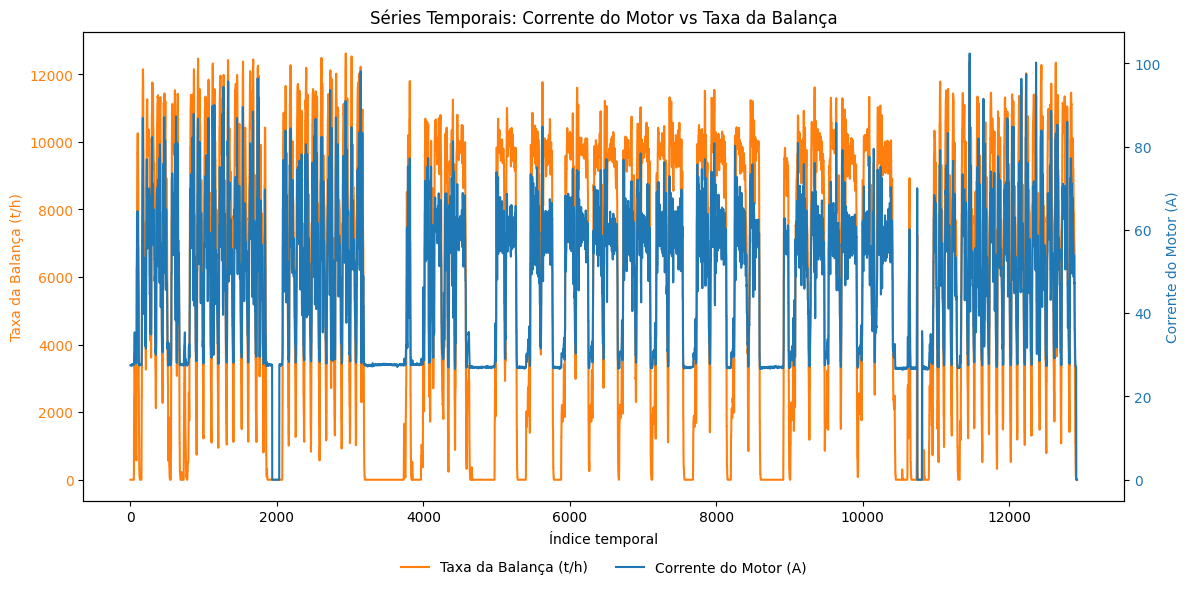

In [190]:
# Estatísticas descritivas
display(df.describe())

# Séries temporais: taxa (eixo principal) e corrente (eixo secundário)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df.index, df['taxa_da_balanca'], color='tab:orange', label='Taxa da Balança (t/h)')
ax1.set_xlabel('Índice temporal')
ax1.set_ylabel('Taxa da Balança (t/h)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

ax2 = ax1.twinx()
ax2.plot(df.index, df['corrente_do_motor'], color='tab:blue', label='Corrente do Motor (A)')
ax2.set_ylabel('Corrente do Motor (A)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax1.set_title('Séries Temporais: Corrente do Motor vs Taxa da Balança')

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

plt.tight_layout()
plt.show()


## 4. Definição do target, variáveis e divisão dos dados

- **Target (variável-alvo):** `taxa_da_balanca` (t/h).  
- **Variável preditora:** `corrente_do_motor` (A).  

- **Divisão dos dados:**  
  - Os primeiros **90% das amostras** são usados para treino e validação, aplicando **validação cruzada** temporal em 5 blocos de tamanho igual.  
  - Os últimos **10% das amostras** formam o conjunto **holdout**, reservado exclusivamente para a avaliação final.  

- **Observação:** Como se trata de **série temporal**, a divisão respeita a ordem cronológica, prevenindo vazamento de informação. O conjunto holdout garante uma avaliação imparcial, simulando um cenário de predição em dados futuros não vistos durante o treino.  


In [191]:
# Definição do problema e divisão dos dados

PROBLEM_TYPE = "regressao"

# Target e feature
target = "taxa_da_balanca"
feature_cols = ["corrente_do_motor"]

X_all = df[feature_cols].copy()
y_all = df[target].copy()

# Separação em treino/validação (CV) e holdout final
holdout_size = int(len(X_all) * 0.1)  # últimos 10% dos dados
split_point = len(X_all) - holdout_size

X_cv, y_cv = X_all.iloc[:split_point], y_all.iloc[:split_point]
X_holdout, y_holdout = X_all.iloc[split_point:], y_all.iloc[split_point:]

# Criar folds usando função definida no tópico 2.3
folds = make_folds(X_cv, y_cv, n_folds=5)

# Resumo
print(f"PROBLEM_TYPE: {PROBLEM_TYPE}")
print(f"Target: {target}")
print(f"N features: {X_all.shape[1]}")
print(f"Treino + Validação (Cross-Validation): {X_cv.shape}")
print(f"Holdout final: {X_holdout.shape}\n")

print("Validação cruzada temporal (5 folds):")
for i, (train_idx, test_idx) in enumerate(folds, 1):
    print(f" - Fold {i}: Validação = amostras {test_idx[0]}–{test_idx[-1]} | Treino = restante")

PROBLEM_TYPE: regressao
Target: taxa_da_balanca
N features: 1
Treino + Validação (Cross-Validation): (11636, 1)
Holdout final: (1292, 1)

Validação cruzada temporal (5 folds):
 - Fold 1: Validação = amostras 0–2326 | Treino = restante
 - Fold 2: Validação = amostras 2327–4653 | Treino = restante
 - Fold 3: Validação = amostras 4654–6980 | Treino = restante
 - Fold 4: Validação = amostras 6981–9307 | Treino = restante
 - Fold 5: Validação = amostras 9308–11634 | Treino = restante


## 5. Tratamento de dados e pipeline de pré-processamento  

Foram definidos dois pré-processadores para avaliar o impacto da normalização no desempenho dos modelos:

- **Raw (sem normalização):** utiliza os dados brutos diretamente.  
- **Scaled (com normalização):** aplica `StandardScaler` sobre a variável preditora.  

Essa abordagem permite comparar se a padronização traz ganhos relevantes para o ajuste dos modelos, especialmente em algoritmos sensíveis à escala dos dados (como regressão linear e métodos baseados em gradiente). Além disso, garante que o scaler seja ajustado apenas nos dados de treino.




In [192]:
# Tratamento de dados e pré-processamento

# Pré-processamento sem normalização (dados brutos)
preprocess_raw = ColumnTransformer(
    transformers=[("pass", "passthrough", feature_cols)],
    remainder="drop"
)

# Pré-processamento com normalização (StandardScaler)
preprocess_scaled = ColumnTransformer(
    transformers=[("scale", StandardScaler(), feature_cols)],
    remainder="drop"
)

print("Pré-processadores definidos:")
print(" - Raw (sem normalização)")
print(" - Scaled (com StandardScaler)")


Pré-processadores definidos:
 - Raw (sem normalização)
 - Scaled (com StandardScaler)


## 6. Baseline e modelos candidatos  

Foi utilizado um **DummyRegressor** como baseline, que prevê sempre a média dos valores de treino. Esse baseline define o limite inferior de desempenho: os modelos precisam superá-lo para demonstrar que de fato capturam padrões nos dados, e não apenas reproduzem estimativas.

Modelos selecionados para comparação:  
- **Ridge Regression** → regressão linear com regularização L2: verificar se uma abordagem linear consegue capturar parte da relação entre corrente e taxa.  
- **Random Forest Regressor** → conjunto de árvores de decisão: robusto para capturar não linearidades sem necessidade de grande pré-processamento.  
- **Gradient Boosting Regressor** → boosting sequencial de árvores: tende a ajustar melhor padrões complexos.  
- **SGD Regressor** → regressão linear otimizada por descida de gradiente: eficiente em bases maiores, mas menos robusto em problemas não lineares, servindo como comparativo com Ridge.  
- **LightGBM** → variante otimizada de gradient boosting: projetada para velocidade e escalabilidade.  
- **CatBoost** → algoritmo de boosting eficiente para dados tabulares: conhecido por bom desempenho consistente e simplicidade de uso.  

Cada modelo foi avaliado em duas versões:  
- **Raw** (dados sem normalização)  
- **Scaled** (dados normalizados com `StandardScaler`)  

A diversidade de modelos permite comparar soluções lineares simples até algoritmos mais sofisticados de ensemble.  


In [193]:
# Baseline e modelos candidatos

# Função de avaliação
def eval_reg(y_true, y_pred, label=''):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return dict(Modelo=label, MAE=mae, RMSE=rmse, R2=r2)

# Função para grid search
def run_grid(pipe, params, Xtr, ytr):
    t0 = time.time()
    gs = GridSearchCV(
        pipe, params,
        scoring='neg_mean_absolute_error',
        cv=3, n_jobs=-1, verbose=0
    )
    gs.fit(Xtr, ytr)
    elapsed = time.time() - t0
    return gs, elapsed

# Definição dos modelos candidatos
models = {
    "Baseline": None,

    "Ridge": (Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('reg', Ridge())
    ]), {
        'poly__degree': [1, 2],
        'reg__alpha': [0.1, 1.0, 10.0]
    }),

    "RandomForest": (Pipeline([
        ('rf', RandomForestRegressor(random_state=SEED))
    ]), {
        'rf__n_estimators': [200, 400],
        'rf__max_depth': [None, 15, 25]
    }),

    "GradientBoosting": (Pipeline([
        ('gb', GradientBoostingRegressor(random_state=SEED))
    ]), {
        'gb__n_estimators': [200, 400],
        'gb__learning_rate': [0.05, 0.1]
    }),

    "SGDRegressor": (Pipeline([
        ('sgd', SGDRegressor(random_state=SEED, max_iter=1000))
    ]), {
        'sgd__alpha': [0.0001, 0.001],
        'sgd__penalty': ['l2', 'l1']
    }),

    "LightGBM": (Pipeline([
        ('lgbm', LGBMRegressor(
            random_state=SEED,
            verbosity=-1   # logs: -1 (sem logs), 0 (erros), 1 (info), >1 (debug detalhado)
        ))
    ]), {
        'lgbm__n_estimators': [200, 400],
        'lgbm__learning_rate': [0.05, 0.1],
        'lgbm__max_depth': [-1, 15, 25]
    }),

    "CatBoost": (Pipeline([
        ('cat', CatBoostRegressor(
            random_state=SEED,
            verbose=0   # logs: 0 (sem saída), >0 imprime a cada N iterações
        ))
    ]), {
        'cat__iterations': [200, 400],
        'cat__learning_rate': [0.05, 0.1],
        'cat__depth': [6, 10]
    })
}


## 7. Validação, Otimização e Resultados  

Os modelos foram treinados e avaliados com **validação cruzada temporal (5 folds)**.
O ajuste de hiperparâmetros foi feito com **GridSearchCV** em cada fold, garantindo que o processo de treino fosse sistemático e comparável.  

#### Métricas utilizadas  
- **MAE (Mean Absolute Error):** erro absoluto médio.  
- **RMSE (Root Mean Squared Error):** erro quadrático médio, mais sensível a outliers.  
- **R² (Coeficiente de Determinação):** proporção da variância explicada pelo modelo.  

Para cada modelo, foram calculadas as métricas em cada fold.  
Os resultados exibidos correspondem à **média dos 5 folds**, acompanhados do **desvio-padrão (± std)**.  

#### Interpretação  
- A **média** mostra o desempenho esperado do modelo.  
- O **desvio-padrão** indica a estabilidade:  
  - Valores baixos → desempenho consistente entre os folds.  
  - Valores altos → menor confiabilidade, devido à maior variação de desempenho entre os folds.   

O **Baseline (DummyRegressor)** não realiza treinamento, por isso o tempo de treino aparece como `NaN`.  
Todas as métricas do baseline foram muito ruins em comparação com os outros modelos, confirmando que a simples média dos valores de treino não seria aplicável em um caso real.  

#### Observação sobre o processo  
Para evitar repetir todo o processo de treino sempre que o notebook for executado, foi incluída a opção de **force_retrain**.  
Por padrão, a variável `force_retrain` está como `False`, mas pode ser alterada para `True` caso seja necessário treinar novamente.  


In [194]:
# 7. Validação, Otimização e Resultados (com salvamento no GitHub)

force_retrain = False  # Coloque True se quiser rodar novamente todo o treino + validação cruzada
model_url = "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/main/best_model.pkl"
model_path = "best_model.pkl"

if not force_retrain:
    try:
        # Sempre baixa a versão mais recente do GitHub
        print("Baixando sempre a versão mais recente do GitHub...")
        r = requests.get(model_url)
        open(model_path, "wb").write(r.content)

        df_cv_mean, best_model = joblib.load(model_path)
        print("Melhor modelo carregado do arquivo salvo!")
    except Exception as e:
        print("Falha ao carregar do GitHub, treinando novamente...", e)
        force_retrain = True

if force_retrain:
    print("Treinando todos os modelos e executando a validação cruzada completa...")

    results = []

    # Loop para Raw e Scaled
    for prep_name, prep in [("Raw", preprocess_raw), ("Scaled", preprocess_scaled)]:
        for name, cfg in models.items():

            if name == "Baseline":
                for i, (train_idx, test_idx) in enumerate(folds, 1):
                    y_train = y_cv.iloc[train_idx]
                    y_test  = y_cv.iloc[test_idx]
                    y_pred  = np.full_like(y_test.values, y_train.mean(), dtype=float)
                    results.append(eval_reg(y_test, y_pred, label=f"{name}_{prep_name}_Fold{i}"))
            else:
                pipe, grid = cfg
                steps = [('prep', prep)] + pipe.steps
                pipe = Pipeline(steps)

                for i, (train_idx, test_idx) in enumerate(folds, 1):
                    X_train, y_train = X_cv.iloc[train_idx], y_cv.iloc[train_idx]
                    X_test,  y_test  = X_cv.iloc[test_idx],  y_cv.iloc[test_idx]

                    gs, dt = run_grid(pipe, grid, X_train, y_train)
                    y_pred = gs.predict(X_test)

                    rec = eval_reg(y_test, y_pred, label=f"{name}_{prep_name}_Fold{i}")
                    rec["TrainTime_s"] = dt
                    results.append(rec)

    df_results = pd.DataFrame(results)
    df_results["Modelo_Base"] = df_results["Modelo"].str.replace(r"_Fold\d+","", regex=True)

    # Estatísticas: média e desvio-padrão das métricas, soma do tempo
    df_cv_mean = (
        df_results
        .groupby("Modelo_Base")
        .agg({
            "MAE": ["mean", "std"],
            "RMSE": ["mean", "std"],
            "R2": ["mean", "std"],
            "TrainTime_s": "sum"
        })
        .reset_index()
    )

    # Renomear colunas para clareza
    df_cv_mean.columns = [
        'Modelo_Base',
        'MAE_mean', 'MAE_std',
        'RMSE_mean', 'RMSE_std',
        'R2_mean', 'R2_std',
        'TrainTime_total'
    ]

    # Ordenar pelo melhor R² médio
    df_cv_mean = df_cv_mean.sort_values(by="R2_mean", ascending=False)

    best_model = df_cv_mean.iloc[0]
    print(f"\n Melhor desempenho médio: {best_model['Modelo_Base']} (R² = {best_model['R2_mean']:.4f} ± {best_model['R2_std']:.4f})\n")

    # Salva apenas os resultados da validação cruzada
    joblib.dump((df_cv_mean, best_model), model_path)

df_cv_mean

Baixando sempre a versão mais recente do GitHub...
Melhor modelo carregado do arquivo salvo!


,Modelo_Base,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,TrainTime_total
2,CatBoost_Raw,551.158718,136.503769,782.349106,169.108716,0.963870,0.015961,72.841702
3,CatBoost_Scaled,551.158718,136.503769,782.349106,169.108716,0.963870,0.015961,73.280021
4,GradientBoosting_Raw,554.374053,134.198591,787.111115,169.214542,0.963446,0.016148,5.756479
5,GradientBoosting_Scaled,554.369239,134.179239,787.122863,169.218925,0.963445,0.016147,6.325721
6,LightGBM_Raw,560.474873,131.879974,793.697565,166.873416,0.962895,0.016111,22.196400
7,LightGBM_Scaled,560.741800,130.579102,796.359093,166.085784,0.962656,0.016129,17.997125
8,RandomForest_Raw,593.652642,139.664632,845.506454,177.857921,0.957870,0.018470,17.222147
9,RandomForest_Scaled,594.320728,139.284392,846.030982,177.181407,0.957831,0.018421,19.795498
13,SGDRegressor_Scaled,1214.373346,161.983108,1509.751410,288.110721,0.866372,0.057691,0.225654
10,Ridge_Raw,1116.015236,143.367158,1525.574753,427.602760,0.857962,0.087550,0.273005


## 8. Avaliação final no Holdout, análise de erros e limitações  

O melhor modelo, selecionado na validação cruzada, foi o **CatBoost_Raw**.  
Ele foi re-treinado em **todo o conjunto de treino/validação (90% dos dados)** e avaliado no **holdout (10%)**, que permaneceu totalmente separado durante o processo.  

Esse conjunto funciona como um **teste final real**, representando um cenário mais próximo da aplicação em produção e permitindo avaliar a capacidade de generalização em dados nunca vistos.  

As métricas finais consideradas foram: **MAE, RMSE e R²**.  

#### Observações  
- A comparação com o **DummyRegressor (baseline)** evidencia o ganho real do modelo sobre uma estratégia ingênua.  
- O uso do holdout garante avaliação imparcial. Apesar do R² no holdout ter sido de **0.89**, ligeiramente abaixo do valor observado em treino/validação (**0.96**), o resultado ainda é considerado muito satisfatório.
- Limitações: quantidade de dados disponível, dependência temporal e a necessidade de uma balança calibrada para garantir que a variável alvo esteja correta e o modelo seja confiável.

In [195]:
# 8. Avaliação final no Holdout (usando o modelo salvo no GitHub)

force_retrain = False  # Coloque True se quiser treinar novamente
model_url = "https://raw.githubusercontent.com/thaygorh/predicao-de-taxa/main/best_model.pkl"
model_path = "best_model.pkl"

if not force_retrain:
    try:
        # Sempre baixa a versão mais recente do GitHub
        print("Baixando sempre a versão mais recente de best_model.pkl...")
        r = requests.get(model_url)
        open(model_path, "wb").write(r.content)

        df_cv_mean, best_model = joblib.load(model_path)
        print("Resultados da validação cruzada carregados com sucesso!")
    except Exception as e:
        print("Falha ao carregar do GitHub, treinando novamente...", e)
        force_retrain = True

if force_retrain:
    print("Treinando novamente o melhor modelo no conjunto treino/validação...")

    results = []
    for prep_name, prep in [("Raw", preprocess_raw), ("Scaled", preprocess_scaled)]:
        for name, cfg in models.items():
            if name == "Baseline":
                continue
            pipe, grid = cfg
            steps = [('prep', prep)] + pipe.steps
            pipe = Pipeline(steps)

            for i, (train_idx, test_idx) in enumerate(folds, 1):
                X_train, y_train = X_cv.iloc[train_idx], y_cv.iloc[train_idx]
                gs, dt = run_grid(pipe, grid, X_train, y_train)

                rec = eval_reg(y_cv.iloc[test_idx], gs.predict(X_cv.iloc[test_idx]),
                               label=f"{name}_{prep_name}_Fold{i}")
                results.append(rec)

    df_results = pd.DataFrame(results)
    df_results["Modelo_Base"] = df_results["Modelo"].str.replace(r"_Fold\d+", "", regex=True)

    df_cv_mean = (
        df_results
        .groupby("Modelo_Base")
        .agg({
            "MAE": ["mean", "std"],
            "RMSE": ["mean", "std"],
            "R2": ["mean", "std"],
            "TrainTime_s": "sum"
        })
        .reset_index()
    )

    df_cv_mean.columns = [
        'Modelo_Base',
        'MAE_mean', 'MAE_std',
        'RMSE_mean', 'RMSE_std',
        'R2_mean', 'R2_std',
        'TrainTime_total'
    ]

    df_cv_mean = df_cv_mean.sort_values(by="R2_mean", ascending=False)
    best_model = df_cv_mean.iloc[0]

    joblib.dump((df_cv_mean, best_model), model_path)
    print(f"Novo modelo salvo em {model_path}")

# Avaliação no Holdout

best_model_name = best_model["Modelo_Base"]

# Identificar se Raw ou Scaled
prep_type = "Raw" if "Raw" in best_model_name else "Scaled"
prep = preprocess_raw if prep_type == "Raw" else preprocess_scaled

# Nome base do modelo
base_name = best_model_name.replace("_Raw", "").replace("_Scaled", "")
pipe, grid = models[base_name]

steps = [('prep', prep)] + pipe.steps
pipe = Pipeline(steps)

# Treinar com todo treino+validação
gs_cv = GridSearchCV(pipe, grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
gs_cv.fit(X_cv, y_cv)
gs = gs_cv.best_estimator_

# Avaliação no Holdout
y_pred_holdout = gs.predict(X_holdout)
rec_best = eval_reg(y_holdout, y_pred_holdout, label=f"{best_model_name}_Holdout")

# Baseline no Holdout
y_pred_baseline = np.full_like(y_holdout.values, y_cv.mean(), dtype=float)
rec_base = eval_reg(y_holdout, y_pred_baseline, label="Baseline_Holdout")

# DataFrame
df_holdout = pd.DataFrame([
    {
        "Modelo_Base": "Baseline",
        "MAE_mean": rec_base["MAE"],
        "MAE_std": 0.0,
        "RMSE_mean": rec_base["RMSE"],
        "RMSE_std": 0.0,
        "R2_mean": rec_base["R2"],
        "R2_std": 0.0,
        "TrainTime_total": 0.0
    },
    {
        "Modelo_Base": best_model_name,
        "MAE_mean": rec_best["MAE"],
        "MAE_std": 0.0,
        "RMSE_mean": rec_best["RMSE"],
        "RMSE_std": 0.0,
        "R2_mean": rec_best["R2"],
        "R2_std": 0.0,
        "TrainTime_total": np.nan
    }
]).round(4)

display(df_holdout)


Baixando sempre a versão mais recente de best_model.pkl...
Resultados da validação cruzada carregados com sucesso!


,Modelo_Base,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std,TrainTime_total
0,Baseline,3092.1737,0.0,3481.2449,0.0,-0.2432,0.0,0.0
1,CatBoost_Raw,776.3221,0.0,1012.8113,0.0,0.8948,0.0,NaN


### 8.1 Visualização das previsões no Holdout  

Para complementar a análise numérica, foi gerada uma visualização das séries temporais no conjunto **holdout**.  
O gráfico compara diretamente:  

- **Taxa da Balança real (t/h)** — valores efetivamente medidos.  
- **Predição da Taxa (t/h)** — valores estimados pelo modelo selecionado (**CatBoost_Raw**).  
- **Corrente do Motor (A)** — exibida no eixo secundário apenas como referência contextual.  

#### Interpretação  
De modo geral, o modelo reproduz de forma consistente o comportamento da taxa de material.
As principais diferenças aparecem em pontos de mudança brusca ou picos curtos, onde a resposta prevista tende a ser suavizada em relação ao valor real.
Ainda assim, o alinhamento entre as curvas indica que o modelo capturou bem a relação entre corrente e fluxo de material.



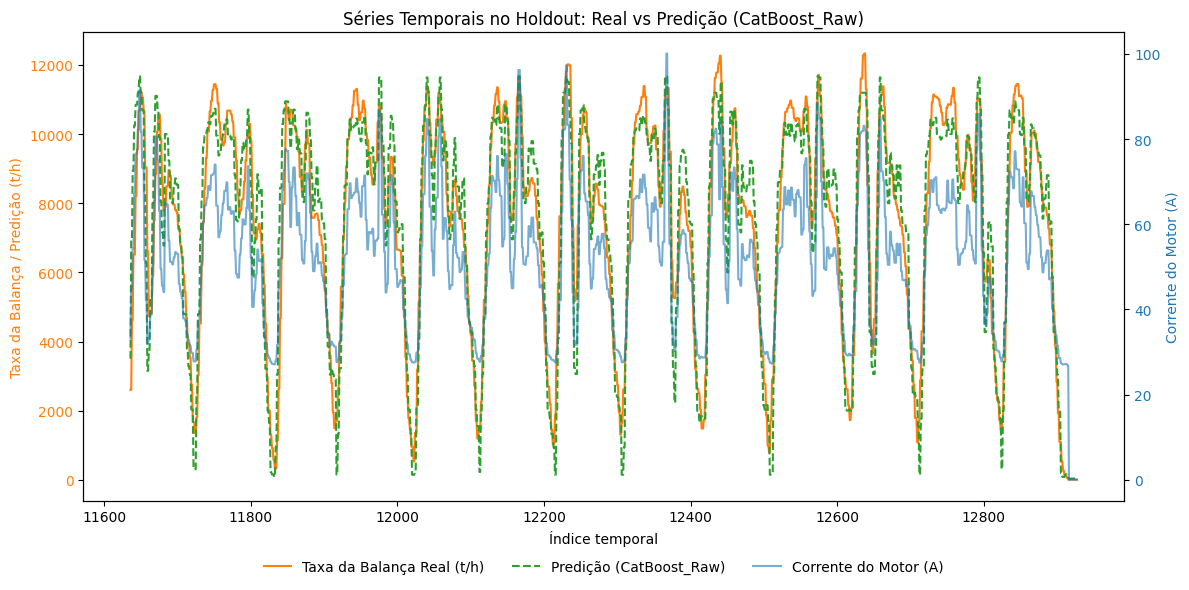

In [196]:
# 8.1 Visualização das previsões (Holdout)

plt.figure(figsize=(12, 6))
ax1 = plt.gca()

# Taxa da Balança real
ax1.plot(y_holdout.index, y_holdout.values, color='tab:orange', label='Taxa da Balança Real (t/h)')

# Predição do modelo selecionado
ax1.plot(
    y_holdout.index, y_pred_holdout,
    color='tab:green', linestyle='--',
    label=f'Predição ({best_model["Modelo_Base"]})'
)

ax1.set_xlabel('Índice temporal')
ax1.set_ylabel('Taxa da Balança / Predição (t/h)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Corrente do Motor no eixo secundário (referência)
ax2 = ax1.twinx()
ax2.plot(X_holdout.index, X_holdout['corrente_do_motor'], color='tab:blue', alpha=0.6, label='Corrente do Motor (A)')
ax2.set_ylabel('Corrente do Motor (A)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Título e legenda
plt.title(f'Séries Temporais no Holdout: Real vs Predição ({best_model["Modelo_Base"]})')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(
    lines_1 + lines_2, labels_1 + labels_2,
    loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False
)

plt.tight_layout()
plt.show()


### 8.2 Curva de resposta do modelo  

Para analisar o comportamento do modelo selecionado, foi simulada uma série de correntes variando de **0,0 a 100,0 A** em passos de **0,1 A**.  

O modelo previu a **Taxa da Balança (t/h)** para cada valor dessa faixa, resultando em uma **curva de resposta** que mostra como ele aprendeu a relacionar a corrente do motor com a taxa prevista.  

#### Interpretação  
Até aproximadamente **83 A**, a curva acompanha bem a relação esperada, indicando que havia dados consistentes nessa faixa para o treinamento.  
Acima desse valor, a curva tende a se estabilizar quase em uma constante, reflexo da escassez de observações nessa região e possivelmente também do limite operacional do motor.  
As previsões feitas a partir dessa faixa devem ser vistas com cautela.  

Essa análise será utilizada no tópico seguinte ao criar uma **função matemática** como forma alternativa de representação, permitindo avaliar se essa aproximação consegue capturar o mesmo comportamento observado no modelo treinado.


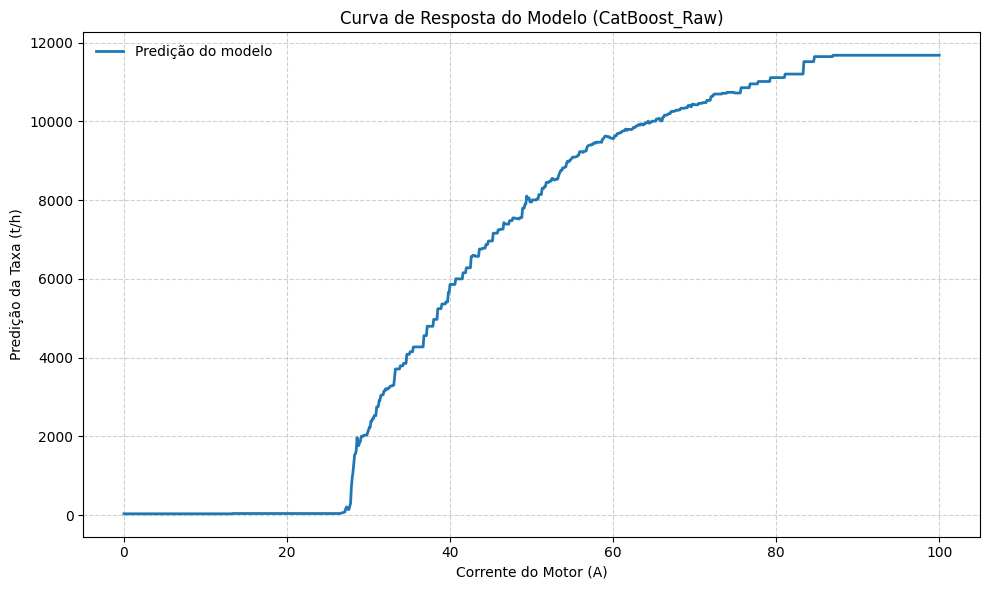

In [197]:
# 8.2 Curva de resposta do modelo

# Geração de correntes simuladas (0 a 100 A, passo 0.1)
corrente_simulada = np.arange(0, 100.1, 0.1)
X_simulado = pd.DataFrame(corrente_simulada, columns=["corrente_do_motor"])

# Predição do modelo treinado (pipeline gs já inclui pré-processador)
y_pred_simulada = gs.predict(X_simulado)

# Gráfico da curva de resposta
plt.figure(figsize=(10, 6))
plt.plot(
    X_simulado["corrente_do_motor"], y_pred_simulada,
    linewidth=2, label="Predição do modelo"
)

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predição da Taxa (t/h)")
plt.title(f"Curva de Resposta do Modelo ({best_model_name})")
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 8.3 Ajuste de função saturante - Global  

A partir da curva de resposta (Tópico 8.2), foi realizado o ajuste de uma **função saturante** (`sat_with_exponent` no código) para avaliar se a relação entre corrente e taxa pode ser representada de forma mais simples.  

A ideia é que abaixo de um certo **limiar físico (τ)** não há taxa de material sendo movimentada, e acima dele a taxa cresce rapidamente até se estabilizar. Essa formulação tem coerência física com o funcionamento do motor e fornece uma representação analítica alternativa e de fácil interpretação.  

#### Etapas  
1. Foi considerada a faixa de **0 a 100 A**.  
2. Definiu-se um **limiar fixo (τ = 27.5 A)** com base no ponto de subida do gráfico.  
3. Os parâmetros **A** (valor assintótico máximo), **k** (taxa de crescimento) e **p** (expoente de curvatura) foram ajustados automaticamente com `curve_fit`, garantindo que não fossem definidos de forma arbitrária, mas extraídos das próprias predições do modelo (**CatBoost_Raw**).  
4. A função ajustada foi então comparada com as predições do modelo para verificar se mantém uma forma coerente e interpretável.  

#### Fórmula matemática  

- y(x) = 0, se x ≤ τ  
- y(x) = A * (1 - exp(-k * (x - τ)^p)), se x > τ

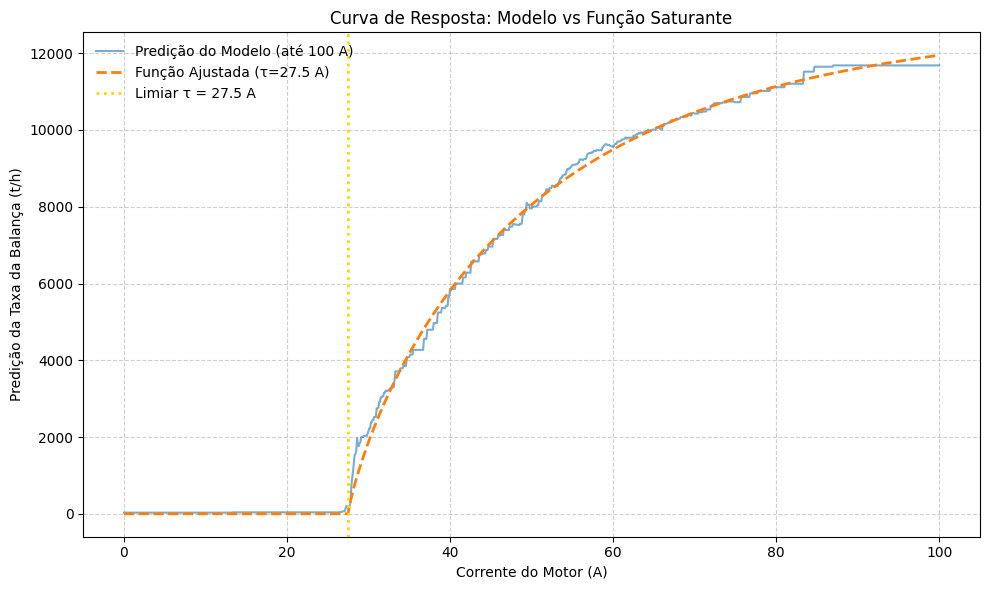

Função ajustada (x em A, y em t/h):
y(x) = 0, se x ≤ 27.5
y(x) = 12911.91 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 27.5


In [198]:
# 8.3 Ajuste de função saturante (com limiar fixo e expoente livre)

# 1) Simulação até 100 A
x = np.arange(0, 100.1, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)

# 2) Definição do limiar τ
tau = 27.5  # limiar físico (A)

# 3) Ajuste dos parâmetros A, k e p usando curve_fit
mask_fit = x > tau
x_fit, y_fit = x[mask_fit], y_model[mask_fit]

# Chutes iniciais
A0 = np.nanpercentile(y_fit, 95) if len(y_fit) else 8000.0
k0, p0 = 0.05, 0.8

popt, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit, y_fit, p0=[A0, k0, p0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_hat, k_hat, p_hat = popt

# 4) Predição da função ajustada
y_fun = sat_with_exponent(x, A_hat, k_hat, p_hat, tau)

# 5) Comparação gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predição do Modelo (até 100 A)")
plt.plot(x, y_fun, linestyle="--", linewidth=2,
         label=f"Função Ajustada (τ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", linewidth=2,
            label=f"Limiar τ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predição da Taxa da Balança (t/h)")
plt.title("Curva de Resposta: Modelo vs Função Saturante")

# Legenda no canto superior esquerdo
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 6) Exibir fórmula final
print("Função ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ≤ {tau:.1f}")
print(f"y(x) = {A_hat:.2f} * (1 - exp(-{k_hat:.4f} * (x - {tau:.1f})^{p_hat:.2f})), se x > {tau:.1f}")


### 8.4 Função saturante - Local  

No Tópico 8.3 foi ajustada a curva global até **100 A**, mas a **subida inicial (27.5 A a 29.9 A)** não foi representada com precisão.  

Para capturar melhor esse comportamento inicial, foi ajustada uma função saturante restrita a esse intervalo, permitindo representar de forma mais fiel a **curva de crescimento inicial**.  

#### Etapas  
1. Considerada a faixa de **0 a 29.9 A**, isolando a região de interesse.  
2. Definido o **limiar fixo (τ = 27.5 A)**, próximo ao ponto em que o motor inicia o transporte efetivo.  
3. Os parâmetros **A** (valor assintótico máximo), **k** (taxa de crescimento) e **p** (expoente de curvatura) foram ajustados automaticamente com `curve_fit`, garantindo que não fossem arbitrários, mas fundamentados nas predições do modelo (**CatBoost_Raw**).  
4. A função ajustada foi comparada às predições do modelo apenas nesse intervalo, verificando sua aderência ao comportamento inicial.  

#### Interpretação  
Esse ajuste captura de forma mais precisa a **primeira curva de subida**, sendo um passo importante para a criação de uma **função híbrida** que combine o comportamento inicial (até 29.9 A) com a curva global (até 100 A).  


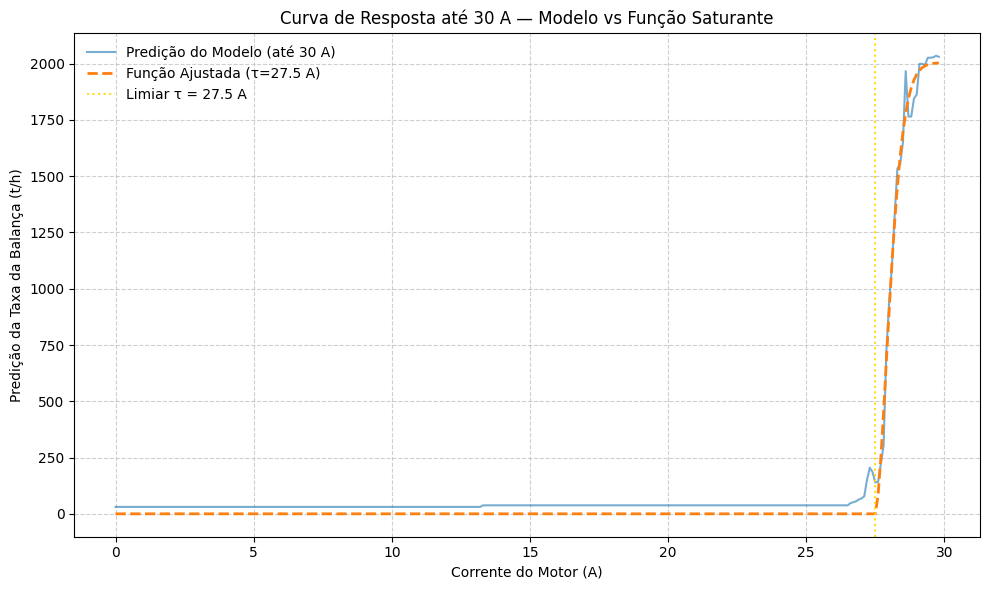

Função ajustada (x em A, y em t/h):
y(x) = 0, se x ≤ 27.5
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se x > 27.5


In [199]:
# 8.4 Função saturante Local

# 1) Simulação até 30 A
x = np.arange(0, 29.9, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)

# 2) Definição do limiar τ
tau = 27.5  # limiar físico (em A)

# 3) Ajuste dos parâmetros A, k e p usando a função auxiliar sat_with_exponent (definida no tópico 2.3)
mask_fit = x > tau
x_fit = x[mask_fit]
y_fit = y_model[mask_fit]

# Chutes iniciais
A0 = np.nanpercentile(y_fit, 95) if len(y_fit) else 8000.0
k0, p0 = 0.05, 0.8

# Ajuste com restrições
popt, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit, y_fit, p0=[A0, k0, p0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_hat, k_hat, p_hat = popt

# 4) Predição da função ajustada
y_fun = sat_with_exponent(x, A_hat, k_hat, p_hat, tau)

# 5) Comparação gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predição do Modelo (até 30 A)")
plt.plot(x, y_fun, linestyle="--", linewidth=2,
         label=f"Função Ajustada (τ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", alpha=0.9,
            label=f"Limiar τ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predição da Taxa da Balança (t/h)")
plt.title("Curva de Resposta até 30 A — Modelo vs Função Saturante")

# Legenda no canto superior esquerdo para evitar sobreposição
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 6) Exibir fórmula final
print("Função ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ≤ {tau:.1f}")
print(f"y(x) = {A_hat:.2f} * (1 - exp(-{k_hat:.4f} * (x - {tau:.1f})^{p_hat:.2f})), se x > {tau:.1f}")


### 8.5 Curva Híbrida: Local (até 29.9 A) + Global (até 100 A)  

Nos tópicos anteriores, vimos que:  
- A curva ajustada pela função global não representava bem a **subida inicial** (27.5 A a 29.9 A).  
- O ajuste local capturou melhor esse comportamento inicial, mas não era adequado para toda a faixa.  

Diante disso, foi criada uma **curva híbrida**, que combina os dois ajustes:  
- **Ajuste Local (27.5 A até 29.9 A):** descreve com maior precisão o início da curva após o limiar.  
- **Ajuste Global (30 A até 100 A):** aplicado somente após o término do ajuste local, representando a tendência geral e a saturação em correntes maiores.  

Essa curva híbrida **não foi definida arbitrariamente**: ela foi construída a partir das **predições do modelo selecionado (CatBoost_Raw)**, servindo como uma representação funcional aproximada da relação aprendida.  

#### Interpretação  
A função híbrida proporciona uma **maior clareza na interpretação**, ao unir as duas curvas em uma formulação bem definida:  
- Uma **subida inicial mais íngreme** (capturada pelo ajuste local).  
- Uma **tendência de saturação gradual** (capturada pelo ajuste global).  

O gráfico mostra que a curva híbrida ficou muito próxima da predição feita pelo modelo.

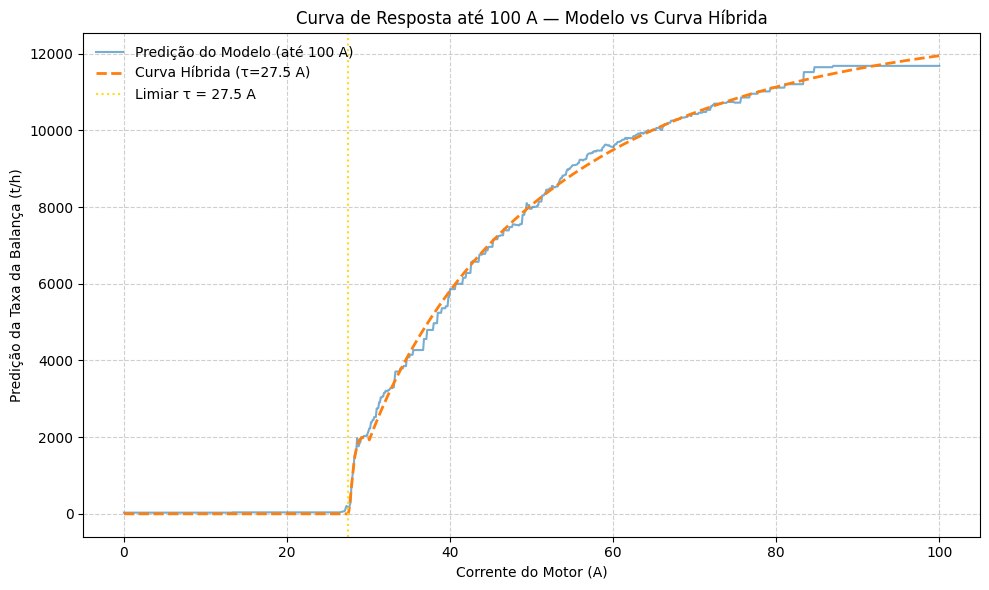

Função Híbrida Ajustada (x em A, y em t/h):
y(x) = 0, se x ≤ 27.5
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se 27.5 < x ≤ 30
y(x) = 12911.90 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 30


In [200]:
# 8.5 Curva Híbrida: Local (até 29.9 A) + Global (até 100 A)

# 1) Simulação do intervalo de interesse
x = np.arange(0, 100.1, 0.1)
X_sim = pd.DataFrame({"corrente_do_motor": x})
y_model = gs.predict(X_sim)  # valores previstos pelo melhor modelo

# 2) Definição do limiar físico
tau = 27.5  # corrente a partir da qual há transporte efetivo

# 3) Ajuste LOCAL (27.8 A até 29.9 A)
mask_fit_loc = (x > tau) & (x <= 29.9)
x_fit_loc, y_fit_loc = x[mask_fit_loc], y_model[mask_fit_loc]

popt_loc, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit_loc, y_fit_loc,
    p0=[2000, 1.0, 2.0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 3.0]),
    maxfev=20000
)
A_loc, k_loc, p_loc = popt_loc

# 4) Ajuste GLOBAL (27.8 A até 100 A)
mask_fit_glob = x > tau
x_fit_glob, y_fit_glob = x[mask_fit_glob], y_model[mask_fit_glob]

popt_glob, _ = curve_fit(
    lambda xv, A, k, p: sat_with_exponent(xv, A, k, p, tau),
    x_fit_glob, y_fit_glob,
    p0=[13000, 0.05, 1.0],
    bounds=([0, 0, 0.1], [np.inf, np.inf, 2.0]),
    maxfev=20000
)
A_glob, k_glob, p_glob = popt_glob

# 5) Construção da curva híbrida
y_hybrid = np.zeros_like(x, dtype=float)
mask_local = (x > tau) & (x <= 30)
mask_global = x > 30

y_hybrid[mask_local] = sat_with_exponent(x[mask_local], A_loc, k_loc, p_loc, tau)
y_hybrid[mask_global] = sat_with_exponent(x[mask_global], A_glob, k_glob, p_glob, tau)

# 6) Comparação gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_model, alpha=0.6, label="Predição do Modelo (até 100 A)", color="tab:blue")
plt.plot(x, y_hybrid, linestyle="--", linewidth=2, color="tab:orange",
         label=f"Curva Híbrida (τ={tau:.1f} A)")
plt.axvline(tau, color="gold", linestyle=":", alpha=0.9, label=f"Limiar τ = {tau:.1f} A")

plt.xlabel("Corrente do Motor (A)")
plt.ylabel("Predição da Taxa da Balança (t/h)")
plt.title("Curva de Resposta até 100 A — Modelo vs Curva Híbrida")

# Legenda no canto superior esquerdo
plt.legend(loc="upper left", frameon=False)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 7) Fórmula final da função híbrida
print("Função Híbrida Ajustada (x em A, y em t/h):")
print(f"y(x) = 0, se x ≤ {tau:.1f}")
print(f"y(x) = {A_loc:.2f} * (1 - exp(-{k_loc:.4f} * (x - {tau:.1f})^{p_loc:.2f})), se {tau:.1f} < x ≤ 30")
print(f"y(x) = {A_glob:.2f} * (1 - exp(-{k_glob:.4f} * (x - {tau:.1f})^{p_glob:.2f})), se x > 30")

### 8.6 Validação prática em Excel  

Para verificar a aplicabilidade da função híbrida fora do ambiente Python, os parâmetros ajustados foram utilizados para gerar um gráfico no **Excel**.  

#### Função Saturante Híbrida  
y(x) = 0, se x ≤ 27.5  
y(x) = 2004.52 * (1 - exp(-1.8704 * (x - 27.5)^1.65)), se 27.5 < x ≤ 30  
y(x) = 12911.90 * (1 - exp(-0.0729 * (x - 27.5)^0.83)), se x > 30  

- No gráfico, a curva híbrida foi identificada na legenda como:  
**Função Saturante Híbrida (y = A·(1 - exp(-k·(x-τ)^p)))**  

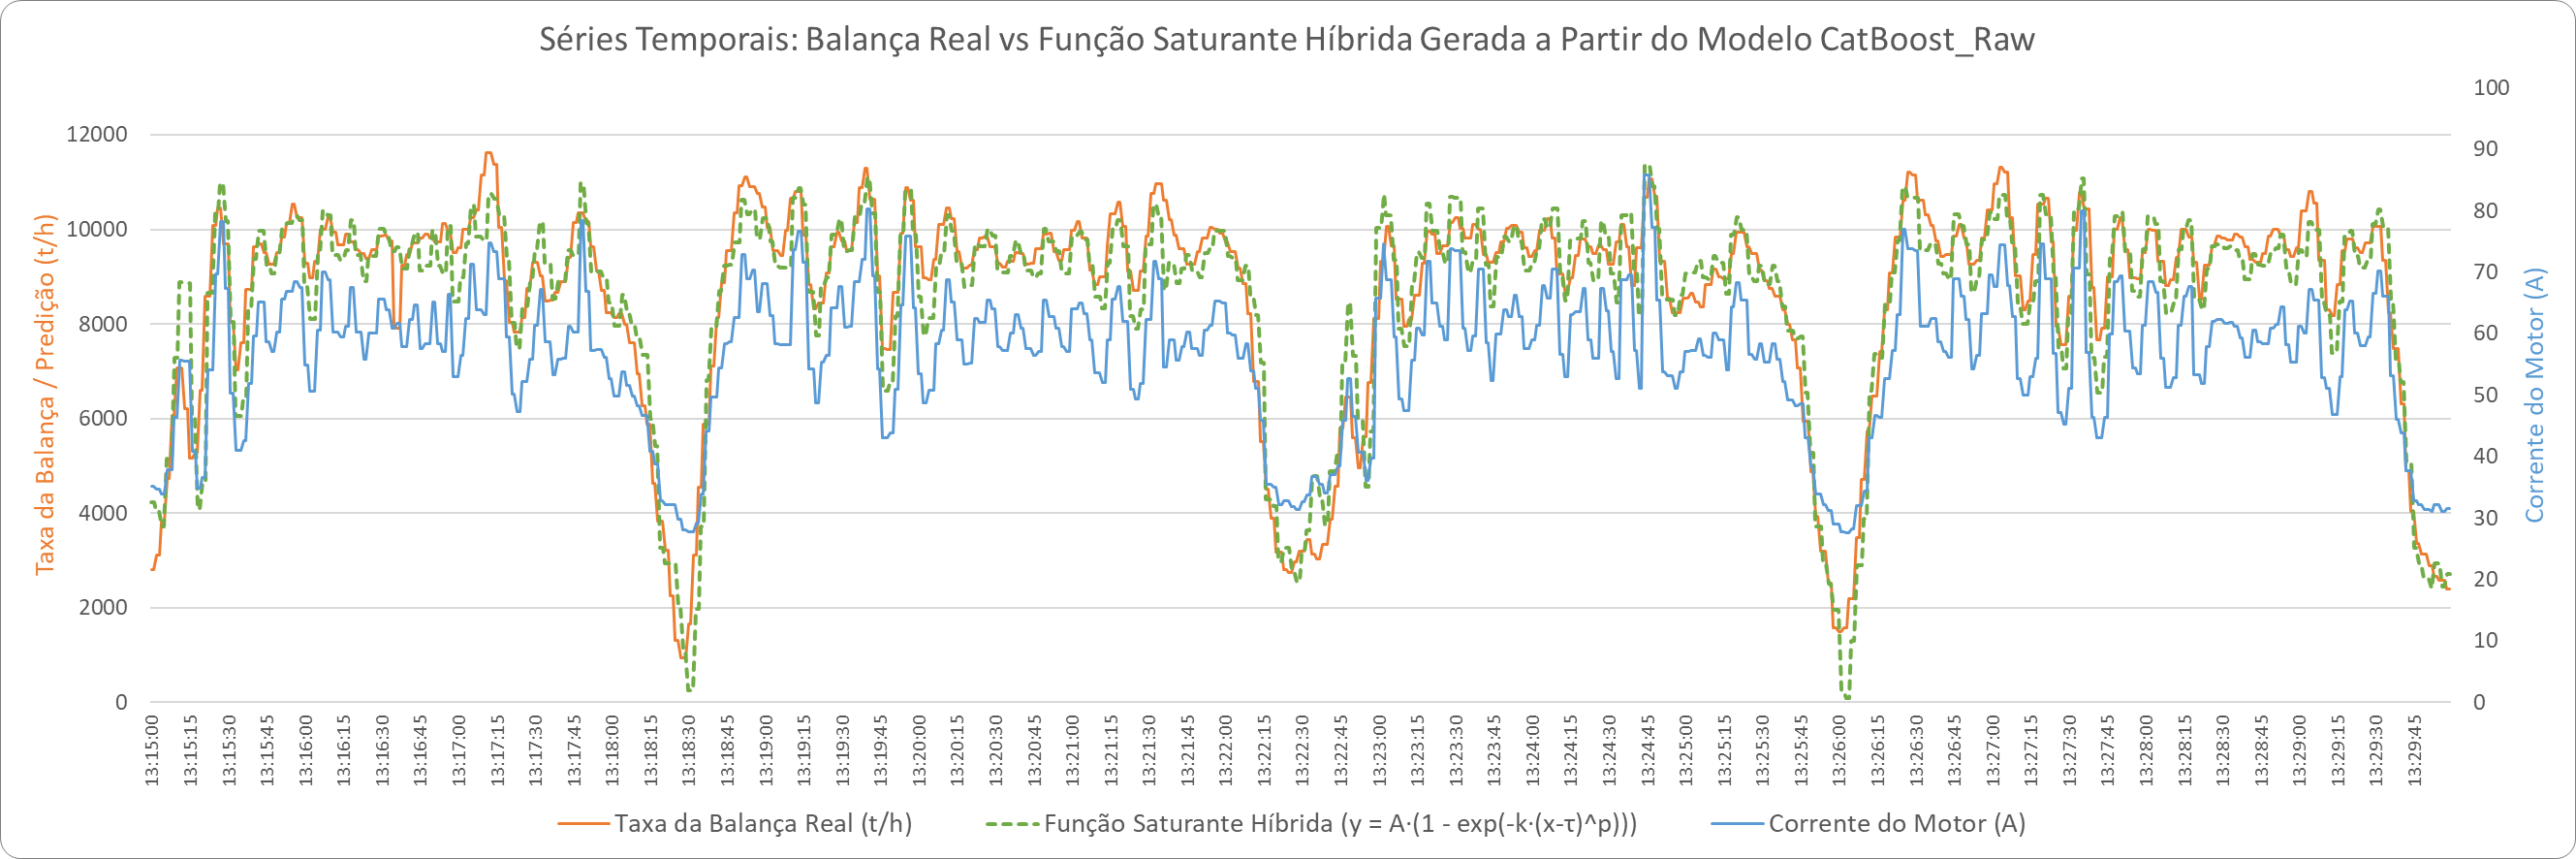

#### Observações  
- A função foi aplicada diretamente sobre os dados reais de **corrente do motor** e comparada com os valores medidos pela **balança**.  
- O resultado reforça que o modelo aprendeu de maneira consistente a relação entre as variáveis.  
- A função deve ser ajustada sempre que novos treinamentos forem realizados.  


## 9. Conclusão  

O objetivo deste trabalho foi validar a viabilidade de realizar a **predição do fluxo de massa a partir da corrente de um motor**, utilizando os dados de uma balança como referência para validação. Para isso, foram testados diferentes modelos de regressão, desde o **DummyRegressor (baseline)** até algoritmos de machine learning mais sofisticados.  

O modelo **CatBoost** apresentou o melhor desempenho, alcançando resultados consistentes nas métricas avaliadas (**MAE, RMSE e R²**) e com **baixo desvio-padrão**, indicando estabilidade e ausência de indícios de underfitting ou overfitting em relação ao baseline.  
Na validação cruzada, o **CatBoost_Raw** atingiu **R² médio de 0.9639 ± 0.0159**, mostrando um bom desempenho e consistência entre os folds.  

#### Observações  
- Outros modelos, como **Gradient Boosting** e **LightGBM**, também apresentaram bom desempenho, embora com resultados ligeiramente inferiores.  
- Apesar dos bons resultados, ainda existem limitações, como a defasagem temporal, que não é fixa, entre a corrente do motor e a leitura da balança e a relação entre o tamanho do dataset e o tempo de treinamento.  
- Futuramente, uma base de dados maior pode contribuir para melhorar a robustez da estimativa, além de refinar a função saturante construída a partir das predições dos modelos.  
- Dessa forma, surgem duas possibilidades de aplicação:  
  1. Utilizar diretamente o modelo com melhor resultado para estimar o fluxo de massa a partir da corrente.  
  2. Adotar a função híbrida derivada das predições do modelo, que mostrou aderência à dinâmica física do motor. Essa alternativa pode trazer vantagens práticas, pois o uso de uma função matemática em vez do carregamento do modelo completo pode tornar o código mais leve e eficiente.  

De forma geral, o estudo demonstrou que é viável prever a taxa de material (t/h) a partir da corrente elétrica do motor analisado, e que a abordagem pode ser estendida para outros sensores industriais.